# Merging the Data and Storing in a Database/Visualizing Data
For this section, I will work on performing the following operations:
- Load the data from the three datasets into a database
- Join the three tables into a single dataset
- Create 5 visualizations on the joined table with each one labeled
    - Use at least 2 visualizations that span across 2 of the tables or data from 2 of the tables in the joined table
- A 250-500-word summary of what I have learned and had to do to complete the project, with ethical implications

## Load necessary libraries

In [3]:
import pandas as pd
import os
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

import requests
from bs4 import BeautifulSoup
pd.set_option('display.max_colwidth', None)
import re

import yfinance as yf
import nbformat
from nbconvert.exporters import PythonExporter

import sqlite3
%matplotlib inline

## Load the datasets from the three data sources

In [5]:
# Define a funciton that reads and executes the notebooks from the previous milestones and load its variables into the current namespace
def execute_notebook(notebook_path):
    try:
        import io
        import sys
        import matplotlib

        original_backend = matplotlib.get_backend() # Save the current matplotlib backend
        matplotlib.use('Agg') # Use 'Agg' backend to suppress matplotlib plots
        
        with open(notebook_path, 'r') as f:
            notebook = nbformat.read(f, as_version=4)
    
        exporter = PythonExporter()
        python_code, _ = exporter.from_notebook_node(notebook) # Convert notebook to Python code

        old_stout = sys.stdout
        sys.stdout = io.StringIO() # Suppress standard output while executing the notebook
    
        # Initiate a local namespace dictionary
        local_namespace = {} 
    
        # Execute the Python code without impacting global namespace or the current local namespace of the notebook
        exec(python_code, globals(), local_namespace) 

        sys.stdout = old_stout # restore standard output

        print(f'Notebook {notebook_path} executed successfully.')
        
        return local_namespace
    except Exception as e:
        sys.stdout = old_stout
        print(f'Error executing notebook {notebook_path}: {e}')
        return None
    finally: 
        matplotlib.use(original_backend) # restore original matplotlib backend

In [6]:
# Load and execute the two notebooks for the ECON data and the world event data
namespace_econ = execute_notebook("DSC540TermProject-Milestone2_Xu.ipynb")
namespace_worldevent = execute_notebook("DSC540TermProject-Milestone3_Xu.ipynb")

Notebook DSC540TermProject-Milestone2_Xu.ipynb executed successfully.
Notebook DSC540TermProject-Milestone3_Xu.ipynb executed successfully.


In [7]:
# Load the notebook for the Yahoo Finance api data 
namespace_stock = execute_notebook("DSC540TermProject-Milestone4_Xu.ipynb")

[*********************100%***********************]  3 of 3 completed


Error executing notebook DSC540TermProject-Milestone4_Xu.ipynb: name 'quarterly_financials' is not defined


Not sure why the above is not working. Assumption is the API data is dynamic which might cause problem to the pythonExporter funciton. Proceeded with the module import alternative below.

In [9]:
# Testing the data of namespace_econ
df_econ = namespace_econ['df_econ']
df_econ.describe()

,date,mthly_yoystkycpilessfoodandenergy_prct,dly_10yrtrsryyield_prct_noadj,mthly_fedfundintrst_prct_noadj,qrtly_gdp_billions,wkly_initjoblessclm,mthly_industrprodindx,mthly_totnonfrm_thousnds,dly_10yr3mthtrsrydiff_prct_noadj,dly_10yrbreakeveninflation_prct,mthly_unemplmnt_prct
count,1706,56.000000,1169.000000,57.000000,18.000000,2.440000e+02,56.000000,57.000000,1001.000000,1169.000000,57.000000
mean,2022-05-02 12:00:00,3.949326,2.586168,2.346140,25149.571833,5.139139e+05,100.379991,150697.350877,0.369750,2.180231,4.989474
min,2020-01-01 00:00:00,1.400569,0.520000,0.050000,19935.444000,1.870000e+05,84.681200,130421.000000,-1.890000,0.500000,3.400000
25%,2021-03-02 06:00:00,2.330213,1.350000,0.090000,22834.810000,2.130000e+05,98.950000,145822.000000,-0.760000,2.140000,3.600000
50%,2022-05-02 12:00:00,4.253590,2.770000,1.550000,25510.641000,2.280000e+05,102.075800,152309.000000,0.560000,2.300000,3.900000
75%,2023-07-02 18:00:00,5.228251,3.910000,5.120000,27381.451000,4.475000e+05,102.918275,156211.000000,1.420000,2.400000,5.800000
max,2024-09-01 00:00:00,6.538167,4.980000,5.330000,29016.714000,6.137000e+06,103.532600,159105.000000,2.270000,3.020000,14.800000
std,NaN,1.643005,1.382620,2.342017,2764.000185,7.781930e+05,3.976661,6867.062757,1.148131,0.417416,2.405253


Matches the original workbook for the Economics data.

In [11]:
# Testing the data of namespace_worldevent
df_worldevent = namespace_worldevent['df_normalized']
print(df_worldevent.shape)
df_worldevent.head()

(745, 2)


,event_date,event_cleaned
0,2020-01-01,"croatia begins its term in the presidency of the european union. flash floods struck jakarta, indonesia, killing 66 people in the worst flooding in over a decade."
1,2020-01-02,january 2 – the royal australian air force and navy are deployed to new south wales and victoria to assist mass evacuation efforts amidst the 2019–20 australian bushfire season .
2,2020-01-03,"january 3 – a united states drone strike at baghdad international airport kills ten people, including the intended target, an iranian general. qasem soleimani and iraqi paramilitary leader abu mahdi al-muhandis ."
3,2020-01-05,"second libyan civil war: president recep tayyip erdoğan announces the deployment of turkish troops to libya on behalf of the united nations-backed government of national accord. 2019–20 croatian presidential election: the second round of voting is held, and zoran milanović of the social democratic party of croatia defeats incumbent president kolinda grabar-kitarović."
4,2020-01-08,"iran launches ballistic missiles at two iraqi military bases hosting u.s. soldiers, injuring over 100 personnel. ukraine international airlines flight 752 was shot down by iranian forces shortly after takeoff from tehran imam khomeini international airport, killing all 176 people on board."


Matches the original workbook for the World Event data.

In [13]:
# Load the module that wrangles the API data and generate the dicionary that contains the stock and fundamendal data for the three tickers
import finalproject_function as fnl
api_data_dict = fnl.stock_api_wrangling()

[*********************100%***********************]  3 of 3 completed


In [14]:
# validation against the dict
null_summary_dict = {}

# Loop through each ticker
for ticker, df in api_data_dict.items():
    null_counts = df.isnull().sum() # Count nulls of each column

    null_percentage = (null_counts / len(df)) * 100 # Calculate null percentage to the dataframe

    null_sum = pd.DataFrame(
        {
            'Null Count': null_counts,
            'Null Percentage (%)': null_percentage
        }
    )

    null_summary_dict[ticker] = null_sum

# Check the null checking results
for ticker, summary in null_summary_dict.items():
    print(f'Null summary for {ticker}:')
    print(summary)
    print('*' * 50)

Null summary for AAPL:
                          Null Count  Null Percentage (%)
Adj Close                          0             0.000000
Close                              0             0.000000
Dividends                       1155            98.381601
High                               0             0.000000
Low                                0             0.000000
Open                               0             0.000000
Stock Splits                    1173            99.914821
Volume                             0             0.000000
Total Revenue                   1170            99.659284
Gross Profit                    1170            99.659284
Operating Expense               1170            99.659284
Research And Development        1170            99.659284
EBITDA                          1170            99.659284
Current Liabilities             1170            99.659284
Free Cash Flow                  1170            99.659284
Basic EPS                       1170            9

Matches the original workbook.

In [16]:
# Combine the dataframes into one
df_apidata = pd.concat(
    {ticker: df.add_suffix(f'_{ticker}') for ticker, df in api_data_dict.items()},
    axis=1
)

# Reset the hierarchical column index
df_apidata.columns = df_apidata.columns.droplevel(0)

In [17]:
# Check the data 
df_apidata.head()

,Adj Close_AAPL,Close_AAPL,Dividends_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Stock Splits_AAPL,Volume_AAPL,Total Revenue_AAPL,Gross Profit_AAPL,...,Stock Splits_TSLA,Volume_TSLA,Total Revenue_TSLA,Gross Profit_TSLA,Operating Expense_TSLA,Research And Development_TSLA,EBITDA_TSLA,Current Liabilities_TSLA,Free Cash Flow_TSLA,Basic EPS_TSLA
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,72.796028,75.087502,NaN,75.150002,73.797501,74.059998,NaN,135480400,NaN,NaN,...,NaN,142981500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,72.088303,74.357498,NaN,75.144997,74.125000,74.287498,NaN,146322800,NaN,NaN,...,NaN,266677500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,72.662697,74.949997,NaN,74.989998,73.187500,73.447502,NaN,118387200,NaN,NaN,...,NaN,151995000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-07,72.320953,74.597504,NaN,75.224998,74.370003,74.959999,NaN,108872000,NaN,NaN,...,NaN,268231500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-08,73.484329,75.797501,NaN,76.110001,74.290001,74.290001,NaN,132079200,NaN,NaN,...,NaN,467164500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Validate the combined dataframe

null_counts = df_apidata.isnull().sum() # Count nulls of each column

null_percentage = (null_counts / len(df)) * 100 # Calculate null percentage to the dataframe

null_sum = pd.DataFrame(
    {
        'Null Count': null_counts,
        'Null Percentage (%)': null_percentage
    }
)

null_sum

,Null Count,Null Percentage (%)
Adj Close_AAPL,0,0.000000
Close_AAPL,0,0.000000
Dividends_AAPL,1155,98.381601
High_AAPL,0,0.000000
Low_AAPL,0,0.000000
Open_AAPL,0,0.000000
Stock Splits_AAPL,1173,99.914821
Volume_AAPL,0,0.000000
Total Revenue_AAPL,1170,99.659284
Gross Profit_AAPL,1170,99.659284


Matches the data before the concatenation.

## Load the data from the three datasets into a database

In [21]:
# Define database 
db_finalprojject = 'finalproject.db'

# Connect to SQLite database 
conn = sqlite3.connect(db_finalprojject)

# load the data form the three datasets into the db
try:
    df_apidata.to_sql('fctapi', conn, if_exists='replace', index=True) # Keep the index as a separate column since it's the date column/index
    df_worldevent.to_sql('fctworldevet', conn, if_exists='replace', index=False)
    df_econ.to_sql('fctecon', conn, if_exists='replace', index=False)
    print('Data has been loaded into the finalproject.db database.')
finally:
    conn.close()

Data has been loaded into the finalproject.db database.


## Join the three tables into a single dataset

In [23]:
# Check the three datasets
conn = sqlite3.connect(db_finalprojject)
for tb in ['fctapi','fctworldevet','fctecon']:
    cursor = conn.cursor()
    cursor.execute(f'SELECT COUNT(*) FROM {tb}')
    print(f'row count for {tb}: {cursor.fetchone()[0]}')

row count for fctapi: 1174
row count for fctworldevet: 745
row count for fctecon: 1706


Matches the data validation above.

In [25]:
# Query the three datasets
for tb in ['fctapi','fctworldevet','fctecon']:
    cursor = conn.cursor()
    cursor.execute(f'SELECT * FROM {tb} LIMIT 1')
    column_names = [description[0] for description in cursor.description]
    first_row = cursor.fetchone()
    for header, value in zip(column_names, first_row):
        print(f'{header}: {value}')
    print('*'*50)

Date: 2020-01-02 00:00:00
Adj Close_AAPL: 72.79602813720703
Close_AAPL: 75.0875015258789
Dividends_AAPL: None
High_AAPL: 75.1500015258789
Low_AAPL: 73.79750061035156
Open_AAPL: 74.05999755859375
Stock Splits_AAPL: None
Volume_AAPL: 135480400
Total Revenue_AAPL: None
Gross Profit_AAPL: None
Operating Expense_AAPL: None
Research And Development_AAPL: None
EBITDA_AAPL: None
Current Liabilities_AAPL: None
Free Cash Flow_AAPL: None
Basic EPS_AAPL: None
Adj Close_NVDA: 5.973121643066406
Close_NVDA: 5.9977498054504395
Dividends_NVDA: None
High_NVDA: 5.9977498054504395
Low_NVDA: 5.918000221252441
Open_NVDA: 5.96875
Stock Splits_NVDA: None
Volume_NVDA: 237536000
Total Revenue_NVDA: None
Gross Profit_NVDA: None
Operating Expense_NVDA: None
Research And Development_NVDA: None
EBITDA_NVDA: None
Current Liabilities_NVDA: None
Free Cash Flow_NVDA: None
Basic EPS_NVDA: None
Adj Close_TSLA: 28.68400001525879
Close_TSLA: 28.68400001525879
Dividends_TSLA: None
High_TSLA: 28.713333129882812
Low_TSLA: 28.

One thing noticed here is all three datasets date columns are in timstamp format. We need to convert to date format.

In [27]:
# Define the SQL Query to load the data into a single dataset
sql_query = """
    CREATE TABLE IF NOT EXISTS merged_data AS
    SELECT
        *
    FROM 
        fctecon a1
    LEFT JOIN fctworldevet a2
        ON a1.date = a2.event_date
    LEFT JOIN fctapi a3
        ON a1.date = a3.Date
"""

cursor = conn.cursor()
cursor.execute("DROP TABLE IF EXISTS merged_data")
cursor.execute(sql_query)
conn.commit()

In [28]:
# Check the new dataset
pd.read_sql("SELECT * FROM merged_data limit 1", conn)

,date,mthly_yoystkycpilessfoodandenergy_prct,dly_10yrtrsryyield_prct_noadj,mthly_fedfundintrst_prct_noadj,qrtly_gdp_billions,wkly_initjoblessclm,mthly_industrprodindx,mthly_totnonfrm_thousnds,dly_10yr3mthtrsrydiff_prct_noadj,dly_10yrbreakeveninflation_prct,...,Stock Splits_TSLA,Volume_TSLA,Total Revenue_TSLA,Gross Profit_TSLA,Operating Expense_TSLA,Research And Development_TSLA,EBITDA_TSLA,Current Liabilities_TSLA,Free Cash Flow_TSLA,Basic EPS_TSLA
0,2020-01-01 00:00:00,2.790484,None,1.55,21727.657,None,101.3372,152045.0,None,None,...,None,None,None,None,None,None,None,None,None,None


In [29]:
pd.read_sql("SELECT * FROM merged_data", conn).shape

(1706, 62)

The dimension of the dataset is correct.

In [31]:
# Check the three date columns form the dataset
cursor.execute(f"PRAGMA table_info({'merged_data'})") # Use PRAGMA command to get column info
columns_info = cursor.fetchall() # Fetch all column info
date_columns = [col[1] for col in columns_info if 'date' in col[1].lower()] # Filter columns where the column name contains 'date'
date_columns

['date', 'event_date', 'Date:1']

In [32]:
# Remove the unncessary date columns
sql_query = """
    ALTER TABLE merged_data DROP COLUMN "event_date";
"""

cursor = conn.cursor()
cursor.execute(sql_query)
conn.commit()

In [33]:
# Remove the unncessary date columns
sql_query = """
    ALTER TABLE merged_data DROP COLUMN "Date:1";
"""

cursor = conn.cursor()
cursor.execute(sql_query)
conn.commit()

In [34]:
# Check the three date columns form the dataset
cursor.execute(f"PRAGMA table_info({'merged_data'})") # Use PRAGMA command to get column info
columns_info = cursor.fetchall() # Fetch all column info
date_columns = [col[1] for col in columns_info if 'date' in col[1].lower()] # Filter columns where the column name contains 'date'
date_columns

['date']

Now it's only 1 left form the parent table, which is what we want. Now let's load the dataset into a dataframe for the next section and close out the connection.

In [36]:
df = pd.read_sql_query("SELECT * FROM merged_data", conn)
conn.close()
df.head()

,date,mthly_yoystkycpilessfoodandenergy_prct,dly_10yrtrsryyield_prct_noadj,mthly_fedfundintrst_prct_noadj,qrtly_gdp_billions,wkly_initjoblessclm,mthly_industrprodindx,mthly_totnonfrm_thousnds,dly_10yr3mthtrsrydiff_prct_noadj,dly_10yrbreakeveninflation_prct,...,Stock Splits_TSLA,Volume_TSLA,Total Revenue_TSLA,Gross Profit_TSLA,Operating Expense_TSLA,Research And Development_TSLA,EBITDA_TSLA,Current Liabilities_TSLA,Free Cash Flow_TSLA,Basic EPS_TSLA
0,2020-01-01 00:00:00,2.790484,NaN,1.55,21727.657,NaN,101.3372,152045.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-02 00:00:00,NaN,1.88,NaN,NaN,NaN,NaN,NaN,0.34,1.80,...,NaN,142981500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-03 00:00:00,NaN,1.80,NaN,NaN,NaN,NaN,NaN,0.28,1.77,...,NaN,266677500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-04 00:00:00,NaN,NaN,NaN,NaN,222000.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-05 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Create 5 visualizations on the joined table with each one labeled

In [38]:
# Check the dataframe columns
df.columns

Index(['date', 'mthly_yoystkycpilessfoodandenergy_prct',
       'dly_10yrtrsryyield_prct_noadj', 'mthly_fedfundintrst_prct_noadj',
       'qrtly_gdp_billions', 'wkly_initjoblessclm', 'mthly_industrprodindx',
       'mthly_totnonfrm_thousnds', 'dly_10yr3mthtrsrydiff_prct_noadj',
       'dly_10yrbreakeveninflation_prct', 'mthly_unemplmnt_prct',
       'event_cleaned', 'Adj Close_AAPL', 'Close_AAPL', 'Dividends_AAPL',
       'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Stock Splits_AAPL',
       'Volume_AAPL', 'Total Revenue_AAPL', 'Gross Profit_AAPL',
       'Operating Expense_AAPL', 'Research And Development_AAPL',
       'EBITDA_AAPL', 'Current Liabilities_AAPL', 'Free Cash Flow_AAPL',
       'Basic EPS_AAPL', 'Adj Close_NVDA', 'Close_NVDA', 'Dividends_NVDA',
       'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Stock Splits_NVDA',
       'Volume_NVDA', 'Total Revenue_NVDA', 'Gross Profit_NVDA',
       'Operating Expense_NVDA', 'Research And Development_NVDA',
       'EBITDA_NVDA', 'Current Liabilit

In [39]:
# First let's correct the format of the date column
df['date'] = pd.to_datetime(df['date']).dt.date
df['date'].head(2)

0    2020-01-01
1    2020-01-02
Name: date, dtype: object

**1. Compare Close Prices Among AAPL, NVDA, AND TSLA**

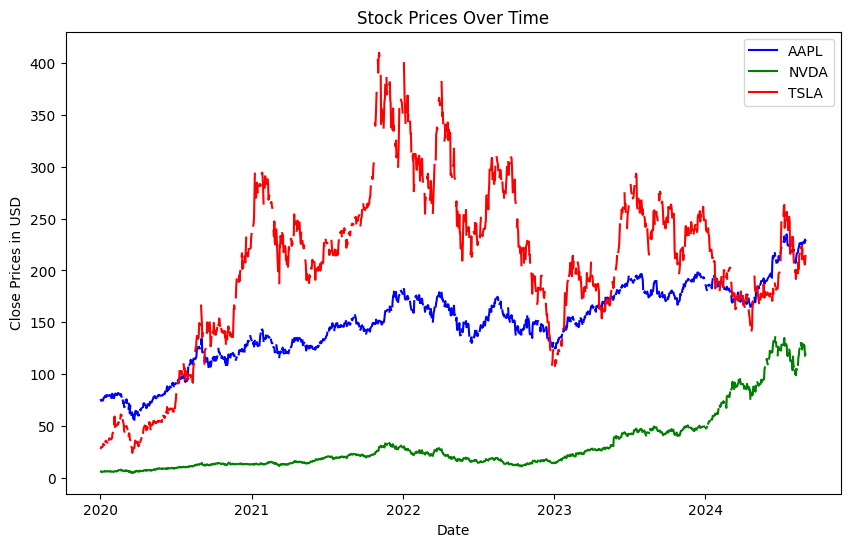

In [41]:
plt.figure(figsize=(10,6))
plt.plot(df['date'], df['Close_AAPL'], label='AAPL', color='blue')
plt.plot(df['date'], df['Close_NVDA'], label='NVDA', color='green')
plt.plot(df['date'], df['Close_TSLA'], label='TSLA', color='red')

plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Prices in USD')

plt.legend()
plt.show()

As we can see, AAPL increased at steady pace, NVDA broke out since 2023 due to AI boom, and TSLA has always been volatile.

**2. Check the Relationship of All Economic Data**

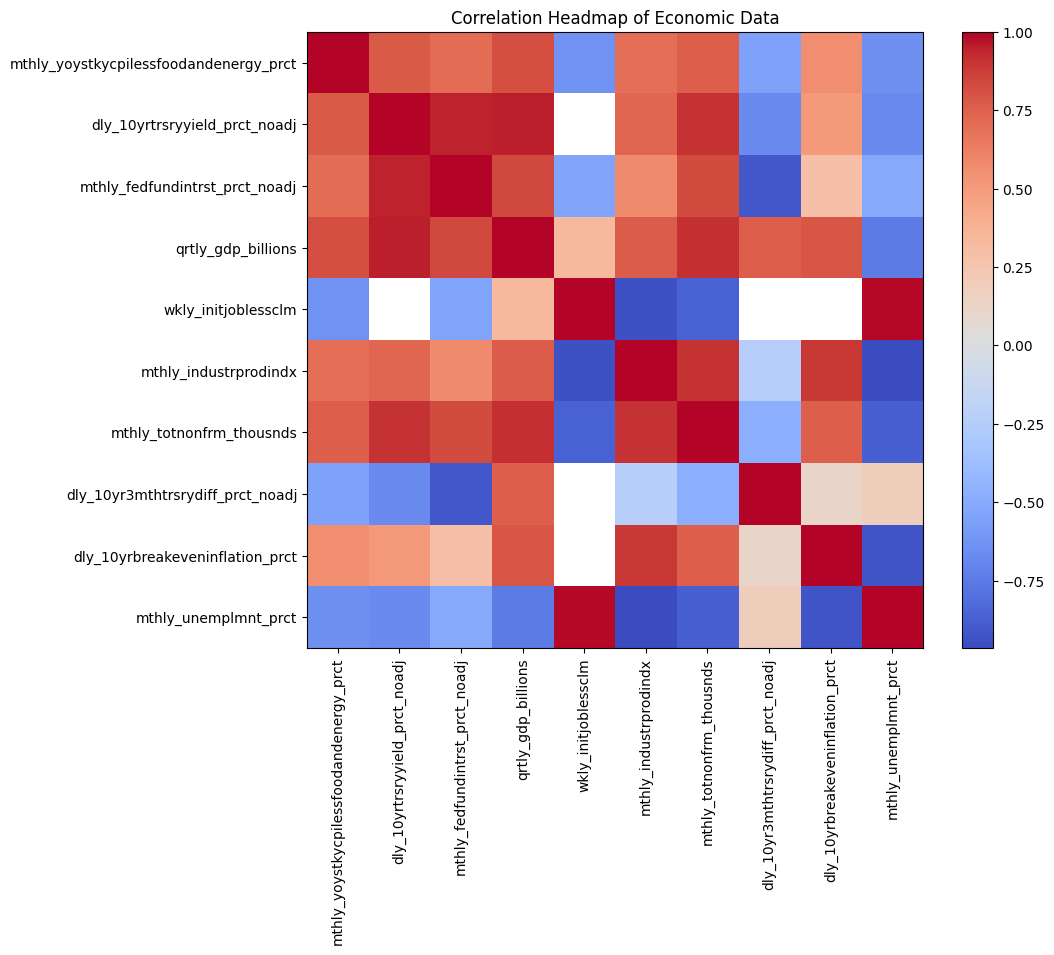

In [44]:
df1 = df.iloc[:, 1:11] # Econ data are in columns from the second to the eleventh column index

# Compute the correlation matrix
corr_matrix = df1.corr()

plt.figure(figsize=(10,8))
plt.imshow(corr_matrix, cmap='coolwarm')
plt.colorbar()

plt.xticks(np.arange(len(df1.columns)), df1.columns, rotation=90) # Adding x ticks 
plt.yticks(np.arange(len(df1.columns)), df1.columns) # Adding y ticks

plt.title('Correlation Headmap of Economic Data')
plt.show()

As we can see, Some fields are in negative relationship whereas some are in positive. One example is the CPI less food and energy has positive relationship with the 10 year treasure yield. When Core CPI rises, price pressures increases, reducing purchasing power of the fixed income from bonds, thus investors will demand higher yield.

**3. Check the Relationship of Economic data and the stock performance of AAPL**

In [47]:
# First let's create a new column that measures the performance of the tickers, based on the close prices, at day to day basis
df['Close_AAPL_DailyChange'] = df['Close_AAPL'].diff()
df['Close_NVDA_DailyChange'] = df['Close_NVDA'].diff()
df['Close_TSLA_DailyChange'] = df['Close_TSLA'].diff()

In [48]:
# Select economic data columns and daily changes columns
price_change_columns = ['Close_AAPL_DailyChange','Close_NVDA_DailyChange','Close_TSLA_DailyChange']

# Combine the columns
analysis_df = pd.concat([df1, df[price_change_columns]], axis=1)

analysis_df.head()

,mthly_yoystkycpilessfoodandenergy_prct,dly_10yrtrsryyield_prct_noadj,mthly_fedfundintrst_prct_noadj,qrtly_gdp_billions,wkly_initjoblessclm,mthly_industrprodindx,mthly_totnonfrm_thousnds,dly_10yr3mthtrsrydiff_prct_noadj,dly_10yrbreakeveninflation_prct,mthly_unemplmnt_prct,Close_AAPL_DailyChange,Close_NVDA_DailyChange,Close_TSLA_DailyChange
0,2.790484,NaN,1.55,21727.657,NaN,101.3372,152045.0,NaN,NaN,3.6,NaN,NaN,NaN
1,NaN,1.88,NaN,NaN,NaN,NaN,NaN,0.34,1.80,NaN,NaN,NaN,NaN
2,NaN,1.80,NaN,NaN,NaN,NaN,NaN,0.28,1.77,NaN,-0.730003,-0.096,0.85
3,NaN,NaN,NaN,NaN,222000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


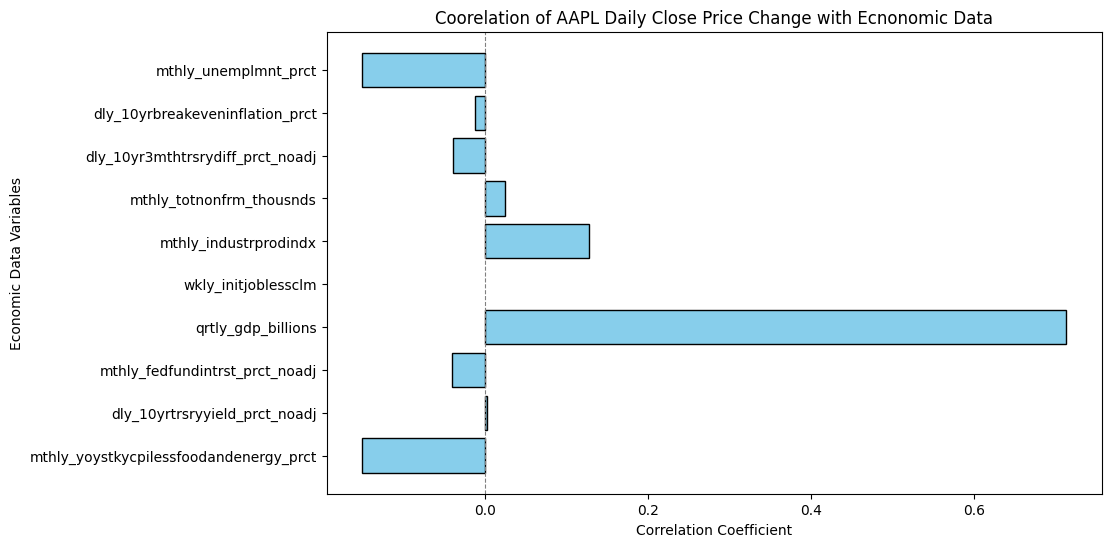

In [49]:
# Compute the correlation matrix for AAPL
df_aapl = analysis_df.iloc[:, :11]
corr_matrix_aapl = df_aapl.corr()['Close_AAPL_DailyChange'].drop('Close_AAPL_DailyChange') 

plt.figure(figsize=(10,6))
plt.barh(corr_matrix_aapl.index, corr_matrix_aapl.values, color='skyblue', edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Economic Data Variables')
plt.title('Coorelation of AAPL Daily Close Price Change with Ecnonomic Data')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.show()

As we can see, AAPL performance has relatively strong positive correlation with quarterly GDP data, and negative relationship with cpi and unemployement rate. High CPI indicates high inflation, which could drive up fed inetrest rate and treasure yield which is what we saw in the previous visualization as well as here, and it could negatively impact company valuation. Unemployment rate increases means economic performance is not doing as well as previously, which could lead to reduction in purchasing power of customers, in turn impacting company revenue and thus valuation.

**4. Check the Relationship of Economic data and the stock performance of NVDA**

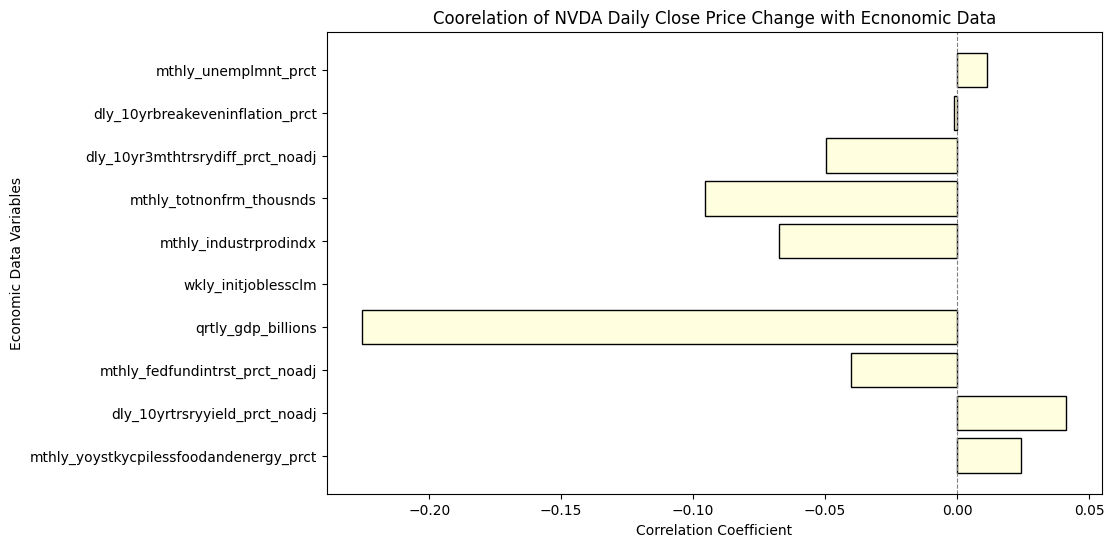

In [52]:
# Compute the correlation matrix for NVDA
df_nvda = analysis_df.iloc[:, list(range(0,10)) + [11]]
corr_matrix_nvda = df_nvda.corr()['Close_NVDA_DailyChange'].drop('Close_NVDA_DailyChange') 

plt.figure(figsize=(10,6))
plt.barh(corr_matrix_nvda.index, corr_matrix_nvda.values, color='lightyellow', edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Economic Data Variables')
plt.title('Coorelation of NVDA Daily Close Price Change with Ecnonomic Data')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.show()

Interestingly, For NVDA the relationship of stock performance and GDP are the opposite of what was between AAPL and GDP, as well as for quite a few other data. This tells us that individual data might perform different for the same kind of Economic data.

**5. Check the Relationship of Economic data and the stock performance of TSLA**

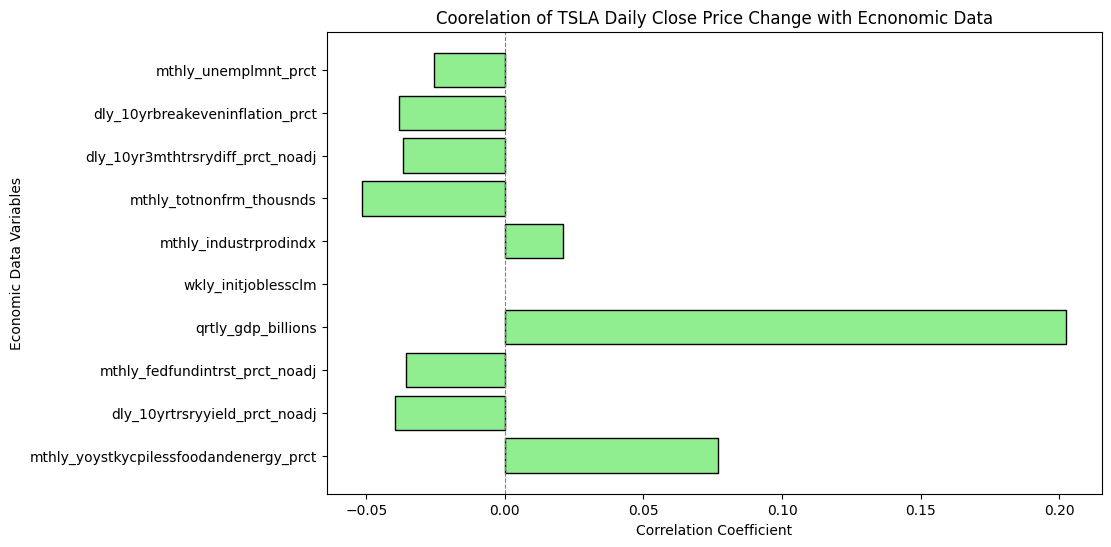

In [55]:
# Compute the correlation matrix for TSLA
df_tsla = analysis_df.iloc[:, list(range(0,10)) + [12]]
corr_matrix_tsla = df_tsla.corr()['Close_TSLA_DailyChange'].drop('Close_TSLA_DailyChange') 

plt.figure(figsize=(10,6))
plt.barh(corr_matrix_tsla.index, corr_matrix_tsla.values, color='lightgreen', edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Economic Data Variables')
plt.title('Coorelation of TSLA Daily Close Price Change with Ecnonomic Data')
plt.axvline(0, color='gray', linestyle='--', linewidth=0.8)

plt.show()

TSLA has more similar relationship with AAPL than with NVDA for its performance and Economic data.

## A 250-500-word summary of what I have learned and had to do to complete the project, with ethical implications

For this project, I explored relationships between economic indicators, world events, and the stock performance/financials of Apple (AAPL), NVIDIA (NVDA), and Tesla (TSLA) with a heavy focus on data wrangling to prepare for the visualization. I integrated data from three sources: government databases for economic data from Federal Reserve Bank of St.Louis, Wikipedia for world events, and the Yahoo Finance API for financial data of the three tickers. Key changes to the data included cleaning and formatting dates, handling missing values, and standardizing column names. The datasets were combined using left joins, with economic data as the primary table, to preserve its integrity. The lack of company financials for the timespan from the Yahoo Finance API poses some hardship to identify true relationship involving company financials. The project adhered to ethical and legal standards, sourcing data from credible and authorized platforms. Government and API data complied with open data and terms-of-service policies, while Wikipedia data was handled within its Creative Commons license requirements. Assumptions, such as the immediate impact of economic events on the stock performances, were documented to ensure transparency. The risks of misalignment or data loss during joins were avoided through careful validation and reproducibility checks. The project emphasized ethical data handling by respecting source guidelines, crediting appropriately, and maintaining rigorous transformation documentation and providing reasonings for doing so. This approach ensured a robust and transparent analysis while safeguarding against ethical and technical pitfalls.